# Прогноз популярности статьи на Habrahabr.ru
[Ссылка](https://inclass.kaggle.com/c/howpop-habrahabr-favs-lognorm) на соревнование.

## Описание
Необходимо предсказать популярность поста на Хабре по содержанию и времени публикации. Как известно пользователи Хабра могут добавлять статьи к себе в избранное. Общее количество пользователей, которое это сделали отображается у статьи количеством звездочек. Будем считать что число звездочек, поставленных статье, наиболее хорошо отражает ее популярность.  

Более формально, в качестве метрики популярности статьи будем использовать долю статей за последний месяц, у которых количество звездочек меньше чем у текущей статьи. А точнее, доле числа звездочек можно поставить в соответствие квантили стандартного распределения, таким образом получаем числовую характеристику популярности статьи. Популярность статьи 0 означает, что статья получила ровно столько звездочек, сколько в среднем получают статьи. И соответственно чем больше звездочек получила статья по сравнению со средним, тем выше это число.

## Оценка качества
Метрика — MSE. Неоходимо построить модель, которая объясняет как можно больше вариации. В силу особенности нормализации целевой переменной, коэффициент детерминации (R2) можно посчитать по формуле R2 = 1 - MSE.

## Загрузка данных

Загрузка библиотек

In [2]:
import re
import ujson
import pickle
import pandas as pd
import numpy as np
from numpy import convolve
from bs4 import BeautifulSoup
import scipy.sparse as sparse

import datetime
import time

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import scale
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

from sklearn.linear_model import *
from sklearn.svm import SVR

import matplotlib.pyplot as plt
%matplotlib inline

Путь к данным

In [3]:
path_to_data = '/home/data/share/habr/'

In [4]:
howpop_test = pd.read_csv(path_to_data + 'howpop_test.csv')
howpop_train = pd.read_csv(path_to_data + 'howpop_train.csv')
sample_submission = pd.read_csv(path_to_data + 'sample_submission.csv')

"Ленивая" загрузка файла

In [8]:
class lazyData:
    def __init__(self, file, key):
        self.file = file
        self.key = key
              
    def __iter__(self):
        with open(self.file, 'r', encoding='utf8') as f:
            data = f.readlines()
            
        for line in data:
            json_row = ujson.loads(line)         
            value = json_row[self.key]
            yield value
    
    def get_keys(self):                                        # получить список полей
        with open(self.file, 'r', encoding='utf8') as f:
            data = f.readlines()
            
        for line in data:
            json_row = ujson.loads(line)
            break
        return json_row.keys()

Генераторы с текстами статей тестового множества

In [13]:
%%time 
test_data = lazyData(path_to_data + 'howpop_test.jsonlines', 'content')
train_data = lazyData(path_to_data + 'howpop_train.jsonlines', 'content')

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 7.87 µs


Поля json-файла с полным описанием контента

In [9]:
test_data.get_keys()

dict_keys(['_spider', 'polling', 'content', 'url', '_id', '_timestamp', 'meta_tags', 'quality', 'hubs', 'post_id', 'tags', 'title', 'domain', 'author', 'flow', 'link_tags', 'published', 'flags'])

## Сериализация данных
"Тяжелые" объекты будем консервировать. Например, частотные матрицы текстов обычно большого размера: не самый удачный вариант пересчитывать их после каждого запуска докуента, поэтому данные матрицы удобно сериализовать с помощью библиотеки *piсkle* и в дальнейшем загружать с диска.

In [10]:
def pickling_data(name, data):
    out = open(name + '.pkl', 'wb')
    pickle.dump(data, out)
    out.close()
    
def load_data(name):
    pkl_file = open(name + '.pkl', 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

## Первичный анализ данных

**Пример статьи**

In [14]:
for sample in train_data:
    print(sample)
    break

Как всегда я плетусь в самом конце WP-движения, это я о скорости реакции на анонсы релизов)<br>
Уже успели выложить и две разные версии русского вордпресса 2.3.2, который только-только сошёл с конвейера (<a href="http://maxsite.org/wp232rus">от Максима </a> и от <a href="http://mywordpress.ru/2007/12/30/wordpress-232/">mywordpress.ru</a>), но, тем не менее, я всё же рискну быть не оригинальным и отписать ещё раз изменения со своими комментариями.<br>
И так, данные взяты из <a href="http://westi.wordpress.com/2007/12/30/wordpress-232-in-detail/">официального анонса</a>.<br><br><a name="habracut"></a><br>
Улучшена производительность, при обработке постов, перед выводом пользователю.<br><br><em>Надеюсь, я правильно понял, то, что написано в <a href="http://trac.wordpress.org/ticket/5325" rel="nofollow">этом тикете</a>.</em><br><em>При выводе поста, да и любой другой страницы, производится множественный вызов функции <strong>get_post</strong>, через которую работают такие функции как <stro

Первое, что бросается в глаза -- это html-тэги, которые явно не несут смысловой нагрузки, поэтому будем очищать текст с помощью библиотеки [BeautifulSoup](http://wiki.python.su/Документации/BeautifulSoup). Также удалим стоп-слова, токенизируем текст, приведем токены к нижнему регистру и выполним лемматизацию токенов.

**Пример сабмита**

In [15]:
sample_submission.head()

,url,favs_lognorm
0,https://habrahabr.ru/post/314080/,0.323588
1,https://habrahabr.ru/company/plesk/blog/313732/,0.560105
2,https://habrahabr.ru/company/etagi/blog/314000/,0.667039
3,https://habrahabr.ru/company/knopka/blog/314030/,0.149563
4,https://geektimes.ru/company/audiomania/blog/2...,0.670754


**Инфо о статьях**  

В таблицах *howpop_train* и *howpop_train* содержится краткая информация о статьях: URL, автор, название статьи, дата публикации и др.

In [16]:
howpop_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134137 entries, 0 to 134136
Data columns (total 17 columns):
url                 134137 non-null object
domain              134137 non-null object
post_id             134137 non-null int64
published           134137 non-null object
author              97657 non-null object
flow                97048 non-null object
polling             134137 non-null bool
content_len         134137 non-null int64
title               134137 non-null object
comments            134137 non-null int64
favs                134137 non-null int64
views               134137 non-null int64
votes_plus          133566 non-null float64
votes_minus         133566 non-null float64
views_lognorm       134137 non-null float64
favs_lognorm        134137 non-null float64
comments_lognorm    134137 non-null float64
dtypes: bool(1), float64(5), int64(5), object(6)
memory usage: 16.5+ MB


In [17]:
howpop_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3990 entries, 0 to 3989
Data columns (total 9 columns):
url            3990 non-null object
domain         3990 non-null object
post_id        3990 non-null int64
published      3990 non-null object
author         2386 non-null object
flow           2668 non-null object
polling        3990 non-null bool
content_len    3990 non-null int64
title          3990 non-null object
dtypes: bool(1), int64(2), object(6)
memory usage: 253.3+ KB


И в обучающем и в тестовом наборе есть пропущенные значения.  
В howpop_train содержится 17 столбцов, а в howpop_test всего 9.

In [18]:
howpop_train.head()

,url,domain,post_id,published,author,flow,polling,content_len,title,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm
0,https://habrahabr.ru/post/18284/,habrahabr.ru,18284,2008-01-01 18:19:00,@Tapac,develop,False,4305,Новогодний подарок блоггерам — WordPress 2.3.2,0,0,236,0.0,0.0,-0.792687,-1.344075,-2.436871
1,https://habrahabr.ru/post/18285/,habrahabr.ru,18285,2008-01-01 18:30:00,@DezmASter,design,False,7344,"Сумасшедшие яйца, или сервис для отслеживания ...",1,1,353,1.0,0.0,-0.485214,-0.831946,-1.873193
2,https://habrahabr.ru/post/18286/,habrahabr.ru,18286,2008-01-01 18:34:00,@DezmASter,design,False,8431,"Сумасшедшие яйца, или сервис для отслеживания ...",47,72,1200,45.0,5.0,0.446090,1.794023,0.574656
3,https://habrahabr.ru/post/18291/,habrahabr.ru,18291,2008-01-02 01:32:00,@Taoorus,design,False,5662,"Сглаживание шрифтов, и субпиксельная отрисовка",102,36,5700,72.0,3.0,1.627469,1.300050,1.167375
4,https://geektimes.ru/post/18294/,geektimes.ru,18294,2008-01-02 14:34:00,@dennydo,NaN,False,3706,Почему мне не нравится iPhone,230,6,1400,73.0,15.0,1.362397,0.961094,2.020356


Все записи расположены в хронологическом порядке -- т.е. данные по сути являются многомерным временным рядом.

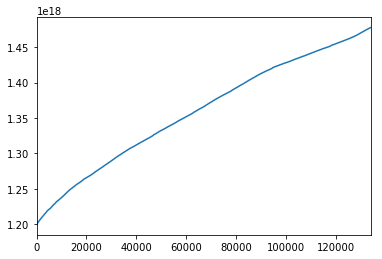

In [19]:
howpop_train['published'].apply(lambda ts: pd.to_datetime(ts).value).plot();

В качестве идентификатора статьи будем использовать поле url.

In [20]:
howpop_train.url.nunique()

134137

Проверим соответствуют ли строка в наборе с контентом записи из таблицы с краткой информацией.

In [21]:
id_train = lazyData(path_to_data + 'howpop_train.jsonlines', 'url')
id_test = lazyData(path_to_data + 'howpop_test.jsonlines', 'url')

In [22]:
for i, Id in enumerate(id_train):
    if Id != howpop_train.iloc[i]['url']:
        print(Id)
print("Если выше нет записей, то всё хорошо!")

Если выше нет записей, то всё хорошо!


In [23]:
for i, Id in enumerate(id_test):
    if Id != howpop_test.iloc[i]['url']:
        print(Id)
print("Если выше нет записей, то всё хорошо!")

Если выше нет записей, то всё хорошо!


---
### Количественные переменные

**Целевая переменная -- favs_lognorm**

По странному стечению обстоятельств **в тестовый набор попал вектор целевой переменной(!)**  
Будем работать только с признаками, которые попали в howpop\_test и непосредственно с текстом статьи.

In [24]:
target = howpop_train.favs_lognorm

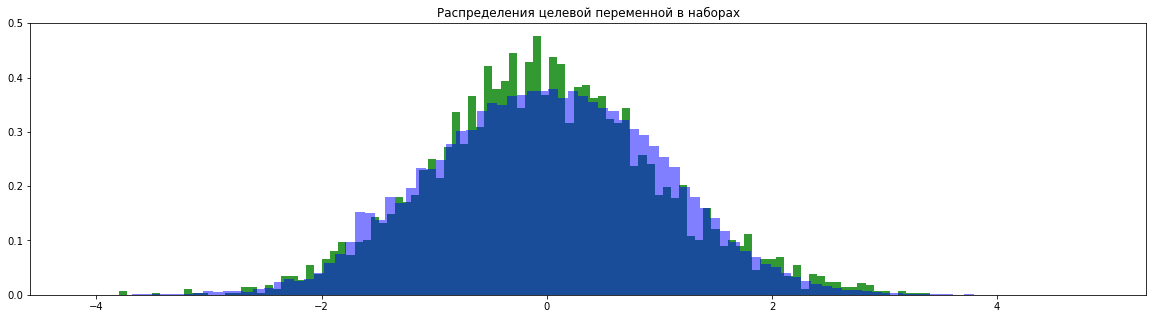

In [25]:
quality_test = lazyData(path_to_data + 'howpop_test.jsonlines', 'quality')
quality_train = lazyData(path_to_data + 'howpop_train.jsonlines', 'quality')

favs_lognorm_test = []
for q in quality_test:
    favs_lognorm = q['favs_lognorm']
    favs_lognorm_test.append(favs_lognorm)

plt.figure(figsize=(20,5))
plt.hist(favs_lognorm_test, bins=100, color='g', alpha=0.8, normed=True)
plt.hist(howpop_train.favs_lognorm, bins=100, color='b', alpha=0.5, normed=True)
plt.title("Распределения целевой переменной в наборах")
plt.show()

**Распределение "звездочек" в train**

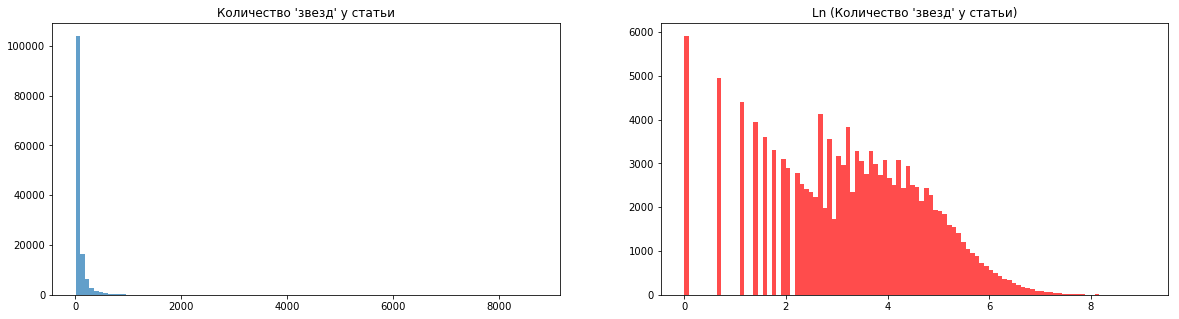

In [26]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(howpop_train.favs + 1, bins=100, alpha=0.7)
plt.title("Количество 'звезд' у статьи")

plt.subplot(1,2,2)
plt.hist(np.log(howpop_train.favs + 1), bins=100, alpha=0.7, color='r')
plt.title("Ln (Количество 'звезд' у статьи)")
plt.show()

In [27]:
print("Третий квартиль: %.2f" % np.percentile(howpop_train.favs.value_counts(), 75))

Третий квартиль: 27.00


Видим, что бOльшая доля статей получает немного "звёзд" (до 27)

**content_len**  

Длина статьи

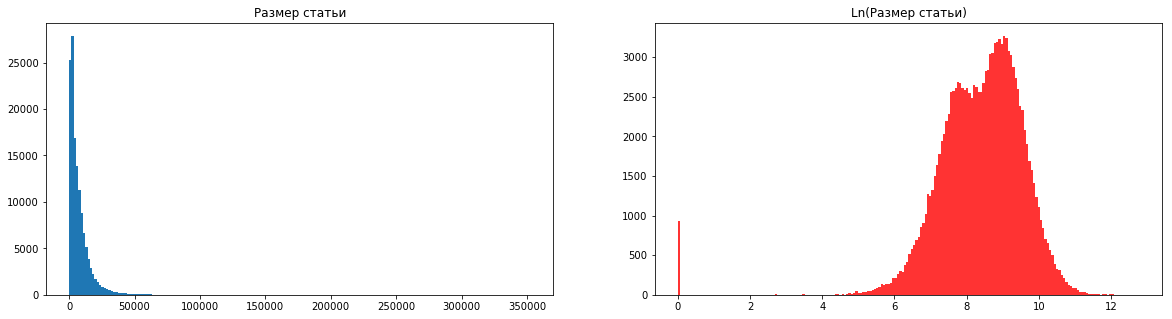

In [28]:
plt.figure(figsize=(20,5))
cont_len = howpop_train.content_len
log_cont_len = np.log(cont_len)

plt.subplot(1,2,1)
plt.title("Размер статьи")
plt.hist(cont_len, bins=200)

plt.subplot(1,2,2)
plt.title("Ln(Размер статьи)")
plt.hist(log_cont_len, bins=200, alpha=0.8, color='r')
plt.show()

In [29]:
print("Корреляция размера статьи с целевой переменной: %.3f" \
      % np.corrcoef(cont_len, howpop_train.favs_lognorm)[0][1])
print("Корреляция сглаженного размера статьи с целевой переменной: %.3f" \
      % np.corrcoef(log_cont_len, howpop_train.favs_lognorm)[0][1])

Корреляция размера статьи с целевой переменной: 0.356
Корреляция сглаженного размера статьи с целевой переменной: 0.411


In [30]:
howpop_train['log_content_len'] = log_cont_len
howpop_test['log_content_len'] = np.log(howpop_test.content_len)

Сглаженный логарифмом признак сильнее коррелирует с целевой переменной, поэтому добавляем его в набор данных

**polling**  

Посмотрим как ниличие опроса влияет на популярность статьи

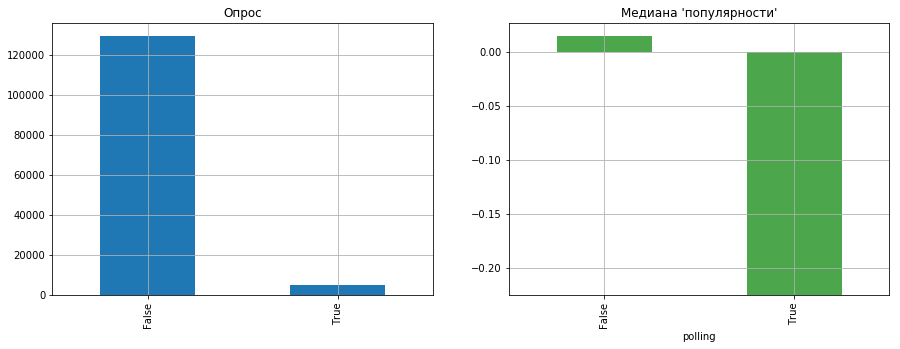

In [31]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
howpop_train.polling.value_counts().plot(kind='bar', grid=True)
plt.title("Опрос")

plt.subplot(1,2,2)
howpop_train.groupby(by='polling').median().favs_lognorm.plot(kind='bar', grid=True, color='g', alpha=0.7)
plt.title("Медиана 'популярности'")
plt.show()

In [32]:
print("Корреляция с целевой переменной: %.3f" % np.corrcoef(howpop_train['polling'], howpop_train.favs_lognorm)[0][1])

Корреляция с целевой переменной: -0.036


---
### Категориальные и временнЫе характеристики

**domain**

In [33]:
howpop_test.domain.value_counts()

habrahabr.ru    2668
geektimes.ru    1322
Name: domain, dtype: int64

In [34]:
howpop_train.domain.value_counts()

habrahabr.ru    97048
geektimes.ru    37089
Name: domain, dtype: int64

Посмотрим где в среднем выше популярность статьи

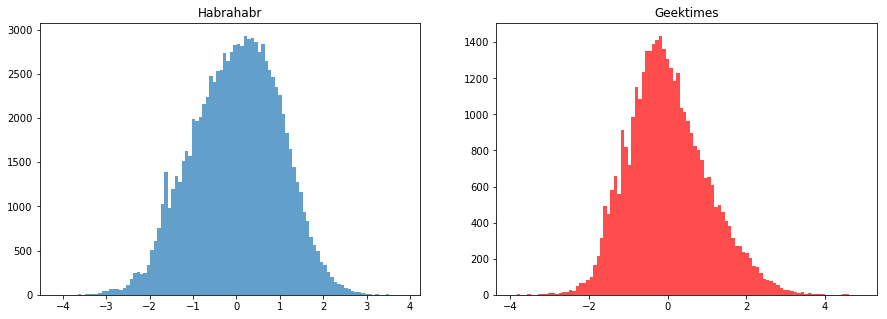

In [35]:
habr = howpop_train[howpop_train.domain == 'habrahabr.ru']
geek = howpop_train[howpop_train.domain == 'geektimes.ru']

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(habr.favs_lognorm, bins=100, alpha=0.7)
plt.title("Habrahabr")

plt.subplot(1,2,2)
plt.hist(geek.favs_lognorm, bins=100, alpha=0.7, color='r')
plt.title("Geektimes")
plt.show()

In [36]:
print("Habrahabr: %.3f" % np.median(habr.favs_lognorm))
print("Geektimes: %.3f" % np.median(geek.favs_lognorm))

Habrahabr: 0.047
Geektimes: -0.090


In [37]:
print("Корреляция с целевой переменной: %.3f" % np.corrcoef(pd.get_dummies(howpop_train.domain)['geektimes.ru'], target)[0][1])

Корреляция с целевой переменной: 0.001


In [38]:
howpop_train['geektimes'] = pd.get_dummies(howpop_train.domain)['geektimes.ru']
howpop_test['geektimes'] = pd.get_dummies(howpop_test.domain)['geektimes.ru']

**flow**

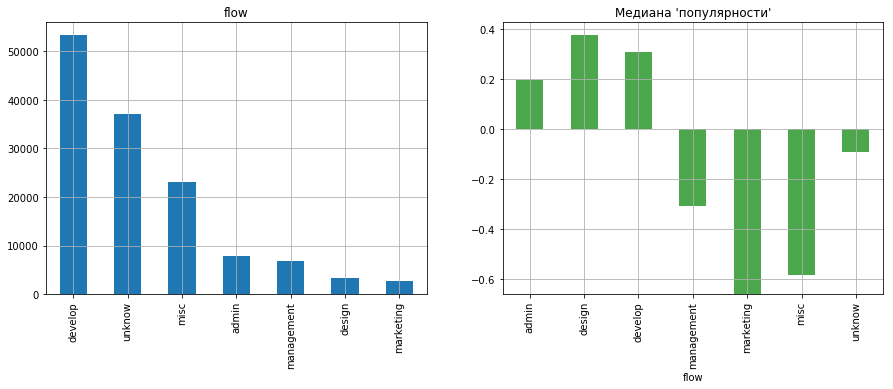

In [39]:
howpop_train.flow.fillna('unknow', inplace=True)
howpop_test.flow.fillna('unknow', inplace=True)

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
howpop_train.flow.value_counts().plot(kind='bar', grid=True)
plt.title("flow")

plt.subplot(1,2,2)
howpop_train.groupby(by='flow').median().favs_lognorm.plot(kind='bar', grid=True, color='g', alpha=0.7)
plt.title("Медиана 'популярности'")
plt.show()

### Дата публикации
**published**

Преобразование даты публикации в Timestamp

In [40]:
howpop_train['published'] = pd.to_datetime(howpop_train['published'])
howpop_test['published'] = pd.to_datetime(howpop_test['published'])

published = howpop_train['published']

In [41]:
# скользящее среднее
def movingaverage (values, window):
    weights = np.repeat(1.0, window) / window
    sma = np.convolve(values, weights, 'valid')
    return sma

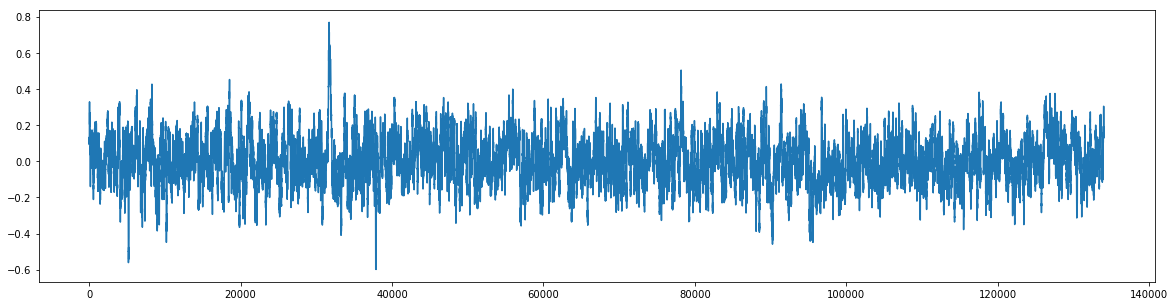

In [42]:
plt.figure(figsize=(20,5))
plt.plot(movingaverage(howpop_train.favs_lognorm, 100))
plt.show()

**Группировка по дням месяца**

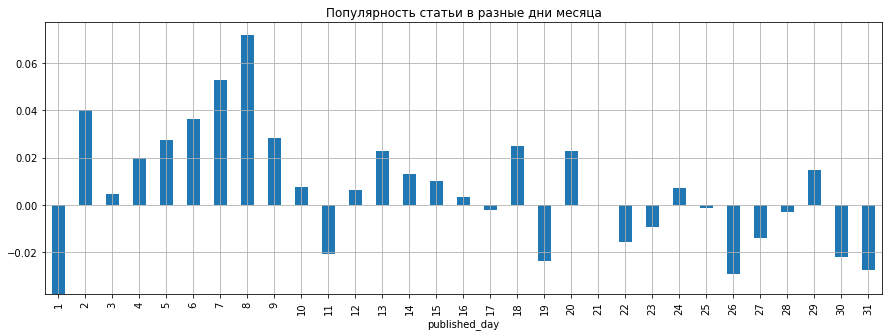

In [43]:
howpop_train['published_day'] = published.apply(lambda x: x.day)

plt.figure(figsize=(15,5))
howpop_train.groupby(by='published_day').median().favs_lognorm.plot(kind='bar', grid=True)
plt.title("Популярность статьи в разные дни месяца")
plt.show()

In [44]:
print("Корреляция с целевой переменной: %.3f" % np.corrcoef(howpop_train['published_day'], howpop_train.favs_lognorm)[0][1])

Корреляция с целевой переменной: -0.011


In [45]:
published_test = pd.to_datetime(howpop_test['published'])
howpop_test['published_day'] = published_test.apply(lambda x: x.day)

**Группировка по дням недели**

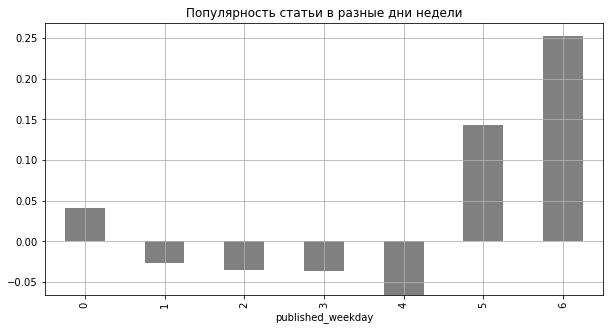

In [46]:
howpop_train['published_weekday'] = published.apply(lambda x: x.weekday())
howpop_test['published_weekday'] = published_test.apply(lambda x: x.weekday())

plt.figure(figsize=(10,5))
howpop_train.groupby(by='published_weekday').median().favs_lognorm.plot(kind='bar', grid=True, color='grey')
plt.title("Популярность статьи в разные дни недели")
plt.show()

In [47]:
print("Корреляция с целевой переменной: %.3f" % np.corrcoef(howpop_train['published_weekday'], howpop_train.favs_lognorm)[0][1])

Корреляция с целевой переменной: 0.034


**Группировка по часам**

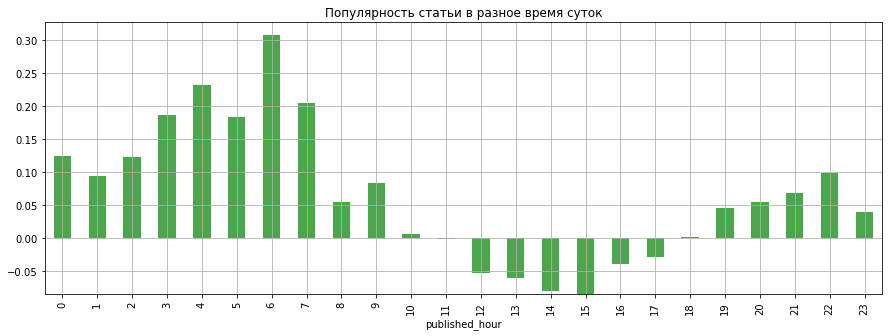

Корреляция с целевой переменной: -0.022


In [48]:
howpop_train['published_hour'] = published.apply(lambda x: x.hour)

plt.figure(figsize=(15,5))
howpop_train.groupby(by='published_hour').median().favs_lognorm.plot(kind='bar', grid=True, color='g', alpha=0.7)
plt.title("Популярность статьи в разное время суток")
plt.show()

print("Корреляция с целевой переменной: %.3f" % np.corrcoef(howpop_train['published_hour'], howpop_train.favs_lognorm)[0][1])

published_test = pd.to_datetime(howpop_test['published'])
howpop_test['published_hour'] = published_test.apply(lambda x: x.hour)

**Популярность статей по годам**

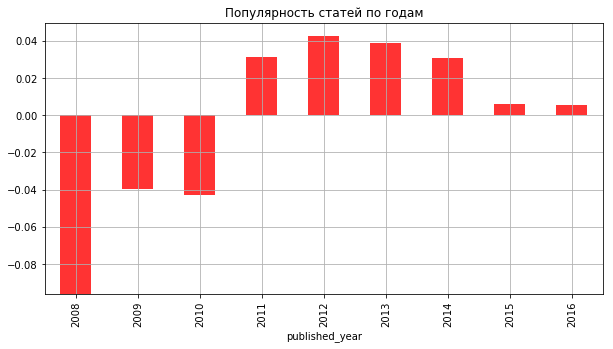

In [49]:
howpop_train['published_year'] = published.apply(lambda x: x.year)

plt.figure(figsize=(10,5))
howpop_train.groupby(by='published_year').median().favs_lognorm.plot(kind='bar', grid=True, color='r', alpha=0.8)
plt.title("Популярность статей по годам")
plt.show()

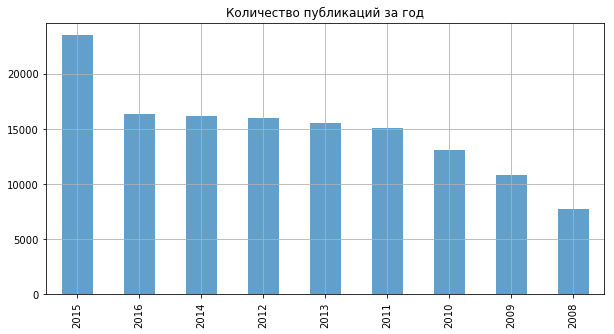

In [50]:
plt.figure(figsize=(10,5))
howpop_train['published_year'].value_counts().plot(kind='bar', alpha=0.7, grid=True)
plt.title("Количество публикаций за год")
plt.show()

**Количество опубликованных статей за сутки**

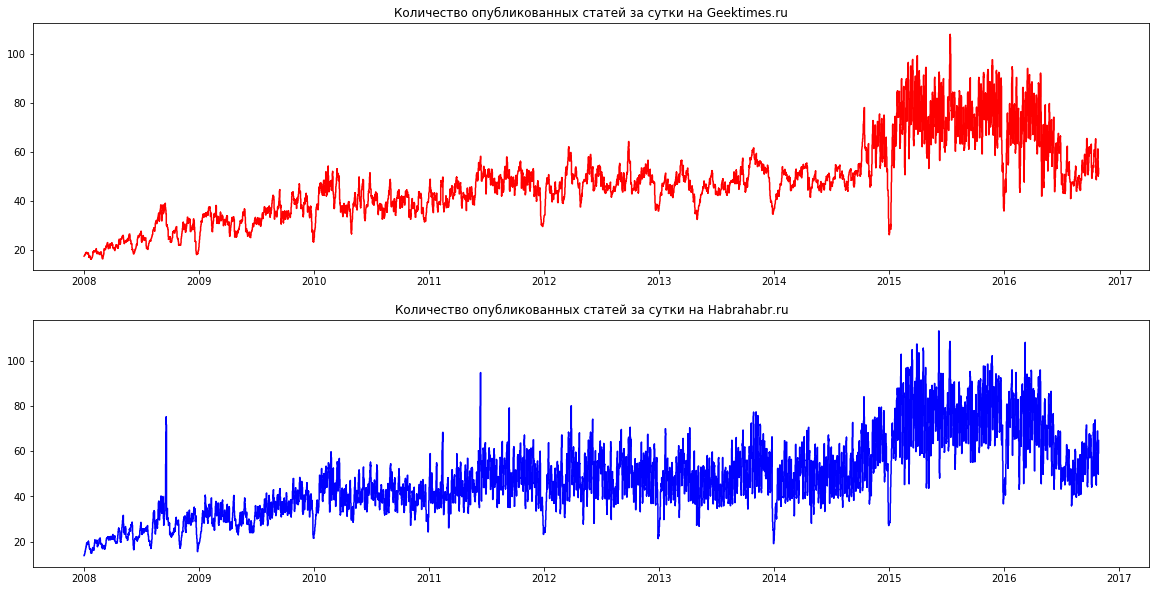

In [51]:
# дата публикации в формате год-месяц-день

howpop_train['published_date'] = published.apply(lambda x: x.date())
howpop_test['published_date'] = published.apply(lambda x: x.date())

howpop_train['pub_date_count'] = howpop_train['published_date'].map(howpop_train.groupby(by='published_date').size())
howpop_test['pub_date_count'] = howpop_test['published_date'].map(howpop_test.groupby(by='published_date').size())


plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
data = howpop_train[howpop_train['domain'] == 'geektimes.ru']
plt.plot(data['published_date'][:-90], movingaverage (data['pub_date_count'], 91), color='r')
plt.title("Количество опубликованных статей за сутки на Geektimes.ru")

plt.subplot(2,1,2)
data = howpop_train[howpop_train['domain'] != 'geektimes.ru']
plt.plot(data['published_date'][:-90], movingaverage (data['pub_date_count'], 91), color='b')
plt.title("Количество опубликованных статей за сутки на Habrahabr.ru")
plt.show()

In [52]:
howpop_train['pub_date_count_log'] = np.log(howpop_train['pub_date_count'])
howpop_test['pub_date_count_log'] = np.log(howpop_test['pub_date_count'])

In [53]:
print("Корреляция с целевой переменной: %.3f" % np.corrcoef(howpop_train['pub_date_count'], howpop_train.favs_lognorm)[0][1])
print("Корреляция сглаженного признака с целевой переменной: %.3f" % np.corrcoef(howpop_train['pub_date_count_log'], howpop_train.favs_lognorm)[0][1])

Корреляция с целевой переменной: -0.048
Корреляция сглаженного признака с целевой переменной: -0.058


### Автор статьи
**author**  

Пропуски заполним

In [54]:
howpop_train.author.fillna('unknow', inplace=True)
howpop_test.author.fillna('unknow', inplace=True)

In [55]:
howpop_train.author.describe()

count     134137
unique     22078
top       unknow
freq       36480
Name: author, dtype: object

In [56]:
howpop_test.author.describe()

count       3990
unique      1132
top       unknow
freq        1604
Name: author, dtype: object

Наиболее активные авторы

In [57]:
howpop_test.author.value_counts()[:10]

unknow               1604
@alizar               156
@marks                135
@SLY_G                107
@ragequit             106
@semen_grinshtein      67
@krasandm              47
@PatientZero           43
@lozga                 23
@ivansychev            22
Name: author, dtype: int64

In [58]:
howpop_train.author.value_counts()[:10]

unknow               36480
@alizar               5292
@marks                4711
@SLY_G                1939
@ivansychev           1350
@semen_grinshtein     1171
@jeston               1060
@aleksandrit           633
@XaocCPS               603
@Mithgol               560
Name: author, dtype: int64

In [59]:
print("Медиана кол-ва статей авторов (train): %.2f" % howpop_train.author.value_counts().median())
print("Медиана кол-ва статей авторов (test): %.2f" % howpop_test.author.value_counts().median())

Медиана кол-ва статей авторов (train): 2.00
Медиана кол-ва статей авторов (test): 1.00


Отметим авторов, чьи статьи обычно набирают высокую популярность

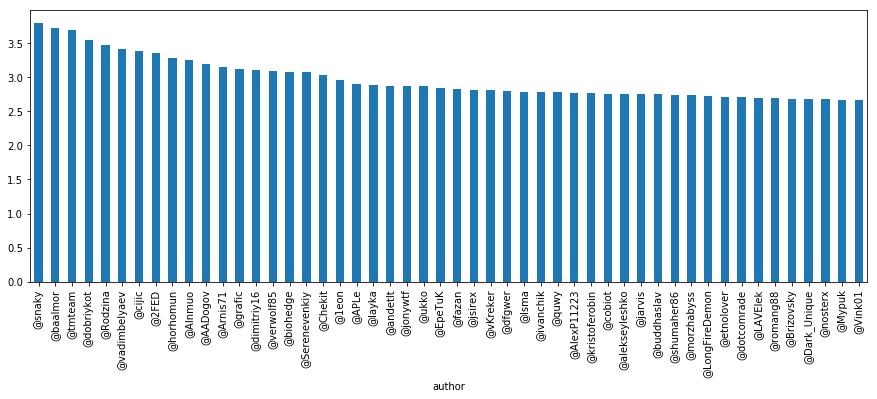

In [60]:
author_pop = howpop_train.groupby(by='author').median()['favs_lognorm'].copy()
author_pop.sort(ascending=False)

plt.figure(figsize=(15,5))
author_pop[:50].plot(kind='bar')

Посмотрим как пересекаются множества авторов в тестовой и обучающей выборках

In [61]:
auth_train = set(howpop_train.author.unique()) 
auth_test = set(howpop_test.author.unique())
auth_inter = list(auth_test.intersection(auth_train))[1:]

print("Количество авторов в train: %d" % len(auth_train))
print("Количество авторов в test: %d" % len(auth_test))
print("Количество авторов, которые есть в test, но не попали в train: %d" % len(auth_test - auth_train))
print("Количество общих авторов: %d" % len(auth_inter))

Количество авторов в train: 22078
Количество авторов в test: 1132
Количество авторов, которые есть в test, но не попали в train: 457
Количество общих авторов: 674


Количество статей из test, которые принадлежат "общим" авторам (включая неизвестных)

In [62]:
sum(howpop_test.author.isin(auth_inter))

3364

In [63]:
# объединяем выборки

howpop = pd.concat((howpop_train, howpop_test), axis=0)
howpop.shape

(138127, 26)

Составим рейтинг популярности для "общих" авторов, т.е. которые попали и в test и в train

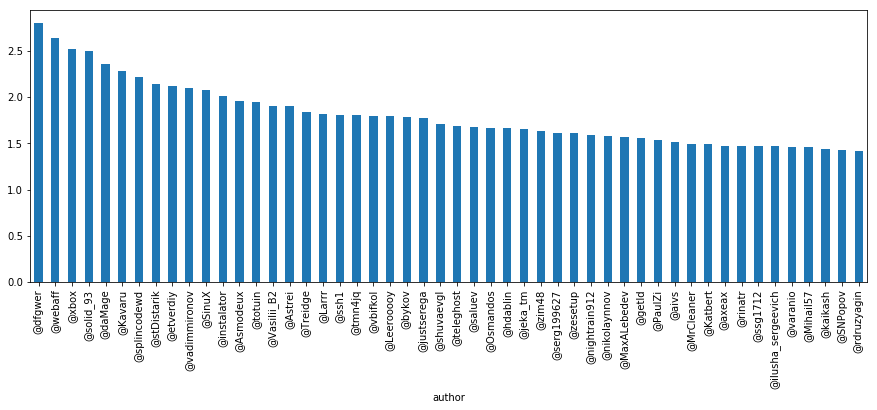

In [64]:
howpop_train_cut = howpop_train[howpop_train.author.isin(auth_inter)]
author_pop = howpop_train_cut.groupby(by='author').median()['favs_lognorm'].copy()
author_pop.sort(ascending=False)

plt.figure(figsize=(15,5))
author_pop[:50].plot(kind='bar')

**Самые активные авторы**

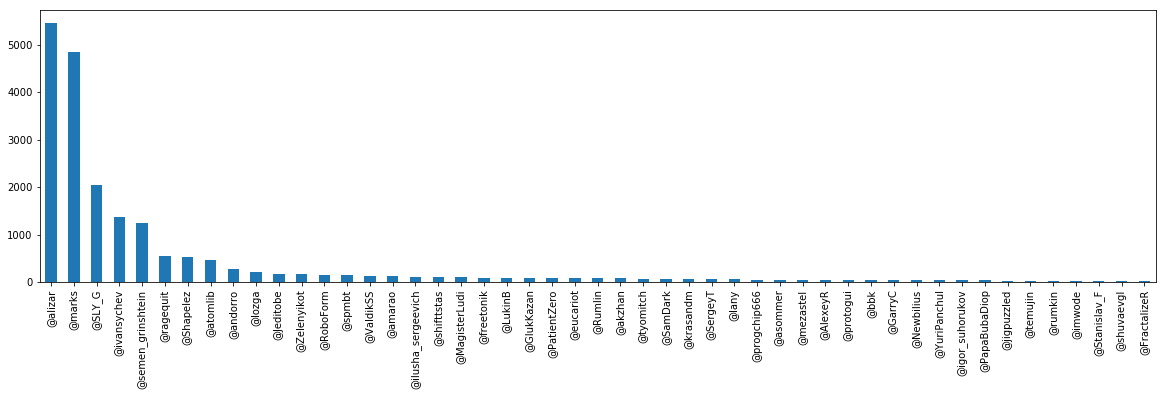

In [65]:
plt.figure(figsize=(20,5))
howpop[howpop.author.isin(auth_inter)].author.value_counts()[1:50].plot(kind='bar')

Авторов, которые попали в обучающее и тестовое множество кодируем one-hot -- получим 674 бинарных фич

In [66]:
def top_author_encoding(dataset, n_top):
    authors = howpop[howpop.author.isin(auth_inter)].author.value_counts()[:n_top].index.tolist()
    encoded = pd.DataFrame()
    for author in authors:
        encoded['author' + author] = np.where(dataset['author'].str.contains(author), 1, 0)
    return encoded

In [67]:
X_train_author = top_author_encoding(howpop_train, 674)
X_test_author = top_author_encoding(howpop_test, 674)

Использывалась линейная регрессия с lasso-регуляризацией для отбора информативных признаков, но это не дало улучшения в дальшейшем, поэтому следующую ячейку я закомментировал и использовал всех "общих" авторов.

In [68]:
'''
model = LassoCV()
model.fit(X_train_author, target)
print("Количество ненулевый коэффициентов: %d" % sum(model.coef_ != 0))

columns = X_test_author.columns

X_train_author = np.array(X_train_author[columns[model.coef_ != 0]])
X_test_author = np.array(X_test_author[columns[model.coef_ != 0]])

X_train_author.shape
'''

'\nmodel = LassoCV()\nmodel.fit(X_train_author, target)\nprint("Количество ненулевый коэффициентов: %d" % sum(model.coef_ != 0))\n\ncolumns = X_test_author.columns\n\nX_train_author = np.array(X_train_author[columns[model.coef_ != 0]])\nX_test_author = np.array(X_test_author[columns[model.coef_ != 0]])\n\nX_train_author.shape\n'

*После селекции осталось 75 признаков*

**Количество статей, опубликованных автором**

In [69]:
howpop_train['author_activity'] = howpop_train['author'].map(howpop.groupby(by=['author']).size()).fillna(2)
howpop_test['author_activity'] = howpop_test['author'].map(howpop.groupby(by=['author']).size()).fillna(1)

**Период активности автора**

In [70]:
def period(author):
    pubs = howpop[howpop.author == author].published
    if len(pubs) == 1:
        period = 0
    else:
        period = (pubs.iloc[-1] - pubs.iloc[0]).days
    return period

In [296]:
%%time
train_period = pd.Series(list(auth_train)).map(lambda x: period(x))
test_period = pd.Series(list(auth_test)).map(lambda x: period(x))

CPU times: user 2min 58s, sys: 66.2 ms, total: 2min 59s
Wall time: 2min 59s


Сериализация

In [297]:
train_period_df = pd.DataFrame(list(train_period), index=list(auth_train), columns=['period'])
test_period_df = pd.DataFrame(list(test_period), index=list(auth_test), columns=['period'])

pickling_data('train_period_df', train_period_df)
pickling_data('test_period_df', test_period_df)

Загрузка

In [71]:
train_period_df = load_data('train_period_df')
test_period_df = load_data('test_period_df')

In [72]:
howpop_train['activity_period'] = howpop_train['author'].map(train_period_df.period)
howpop_test['activity_period'] = howpop_test['author'].map(test_period_df.period)

**Среднее количество публикаций за период активности автора**

In [73]:
howpop_train['activity_ratio'] = howpop_train['author_activity'] / (howpop_train['activity_period'] + 1)
howpop_test['activity_ratio'] = howpop_test['author_activity'] / (howpop_test['activity_period'] + 1)

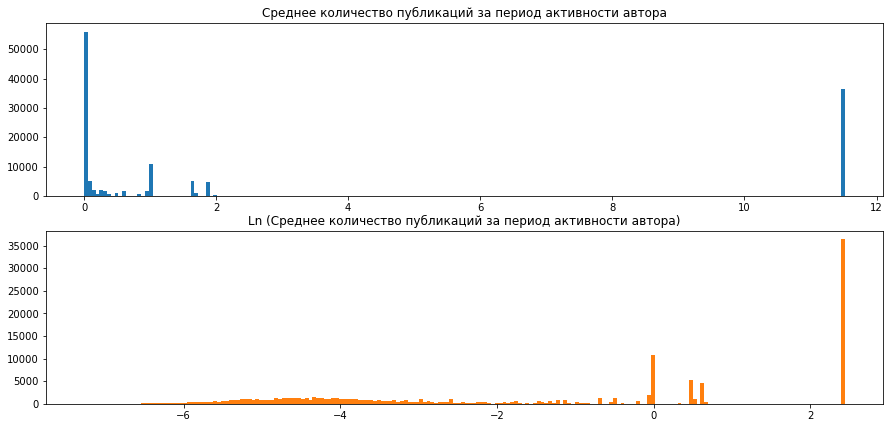

In [74]:
plt.figure(figsize=(15,7))
plt.subplot(2,1,1)
plt.title("Среднее количество публикаций за период активности автора")
plt.hist(howpop_train['activity_ratio'], bins=200)

plt.subplot(2,1,2)
plt.title("Ln (Среднее количество публикаций за период активности автора)")
plt.hist(np.log(howpop_train['activity_ratio']), bins=200)

plt.title("Ln (Среднее количество публикаций за период активности автора)")
plt.hist(np.log(howpop_train['activity_ratio']), bins=200)
plt.show()

Экстремальное значение, которое можно наблюдать справа на графиках, соответствует "неизвестному" автору.

In [75]:
print("Корреляция признака с целевой переменной: %.3f" % np.corrcoef(howpop_train['activity_ratio'], howpop_train.favs_lognorm)[0][1])
print("Корреляция сглаженного признака с целевой переменной: %.3f" % np.corrcoef(np.log(howpop_train['activity_ratio']), howpop_train.favs_lognorm)[0][1])

Корреляция признака с целевой переменной: -0.185
Корреляция сглаженного признака с целевой переменной: -0.231


In [76]:
howpop_train['activity_ratio_log'] = np.log(howpop_train['author_activity'] / (howpop_train['activity_period'] + 1))
howpop_test['activity_ratio_log'] = np.log(howpop_test['author_activity'] / (howpop_test['activity_period'] + 1))

---
## Формирование выборок
Тестовый набор составляет ~3% обучающего. Аналогично тому как была сформирована тестовая выборка, составим валидационную выборку. От обучающей выборки "отрежем" 4000 записей, на которых будем проверять качество моделей.

In [77]:
target = howpop_train.favs_lognorm
target_train = target[:-4000]
target_valid = target[-4000:]

In [78]:
print("Размер обучающего множества: %d" % len(target_train))
print("Размер валидационного множества: %d" % len(target_valid))
print("Размер тестового множества: %d" % howpop_test.shape[0])

Размер обучающего множества: 130137
Размер валидационного множества: 4000
Размер тестового множества: 3990


Признаки

In [79]:
cols = ['geektimes', 'flow', 'log_content_len', 'published_weekday', 'published_hour', 'activity_ratio_log']

howpop_test.columns

Index(['url', 'domain', 'post_id', 'published', 'author', 'flow', 'polling',
       'content_len', 'title', 'log_content_len', 'geektimes', 'published_day',
       'published_weekday', 'published_hour', 'published_date',
       'pub_date_count', 'pub_date_count_log', 'author_activity',
       'activity_period', 'activity_ratio', 'activity_ratio_log'],
      dtype='object')

In [80]:
%%time

X_train_num = scale(np.array(pd.get_dummies(howpop_train[cols])).astype('float64'), axis=0)
X_valid_num = X_train_num[-4000:]
X_train_num = X_train_num[:-4000]
X_test_num = scale(np.array(pd.get_dummies(howpop_test[cols])).astype('float64'), axis=0)

X_train_sparse = sparse.csr_matrix(np.hstack((X_train_author[:-4000], X_train_num)))
X_valid_sparse = sparse.csr_matrix(np.hstack((X_train_author[-4000:], X_valid_num)))
X_test_sparse = sparse.csr_matrix(np.hstack((X_test_author, X_test_num)))

CPU times: user 1.28 s, sys: 0 ns, total: 1.28 s
Wall time: 1.28 s


Построим простую модель линейной регрессии с l2-регуляризацией и обучим её на сформированных данных

In [81]:
model = Ridge()
model.fit(X_train_sparse, target_train)
pred = model.predict(X_valid_sparse)
print("Score: %.3f" % mean_squared_error(target_valid, pred))

Score: 0.816


----
## Работа с текстовыми признаками

### Заголовки статей
**title**  
Названия статей разобьем на токены, приведем к нижнему регистру и преобразуем в нормальную форму (лемматизация). Затем выполним векторизацию -- представим заголовки статей в виде частотной матрицы (термины-на-документы)

In [82]:
import nltk
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [83]:
howpop_train.title[:5]

0       Новогодний подарок блоггерам — WordPress 2.3.2
1    Сумасшедшие яйца, или сервис для отслеживания ...
2    Сумасшедшие яйца, или сервис для отслеживания ...
3       Сглаживание шрифтов, и субпиксельная отрисовка
4                        Почему мне не нравится iPhone
Name: title, dtype: object

In [84]:
def lemmatization(word):
    lemma = morph.parse(word)[0].normal_form
    return lemma

def title_cleaning(text, lemma=False, punc=False):
    tokens = nltk.wordpunct_tokenize(text)
    tokens = [token.lower() for token in tokens]
    if not punc:
        tokens = [token for token in tokens if token.isalnum()]
    if lemma:
        tokens = [lemmatization(token)for token in tokens]
    return ' '.join(tokens)

In [85]:
%%time

titles = list(howpop_train.title)
titles_test = list(howpop_test.title)

title_train_punc = [title_cleaning(title, punc=True) for title in titles]
title_test_punc = [title_cleaning(title, punc=True) for title in titles_test]

title_train_lemma = [title_cleaning(title, lemma=True) for title in titles]
title_test_lemma = [title_cleaning(title, lemma=True) for title in titles_test]

title_train = [title_cleaning(title) for title in titles]
title_test = [title_cleaning(title) for title in titles_test]

CPU times: user 24.6 s, sys: 32.3 ms, total: 24.6 s
Wall time: 24.6 s


"Очищенные" заголовки статей

In [86]:
title_train[20:25]

['оперное мини расследование',
 'хочу телебраузер',
 'opera 9 5 sdk для устройств',
 'и снова о популярности',
 'установка драйвера для видяхи nvidia в ubuntu 7 10']

In [87]:
title_train_lemma[20:25]

['оперный минь расследование',
 'хотеть телебраузер',
 'opera 9 5 sdk для устройство',
 'и снова о популярность',
 'установка драйвер для видяха nvidia в ubuntu 7 10']

In [88]:
title_train_punc[20:25]

['оперное мини - расследование',
 'хочу телебраузер !',
 'opera 9 . 5 sdk для устройств',
 'и снова о популярности',
 'установка драйвера для видяхи nvidia в ubuntu 7 . 10']

In [89]:
titles_train = [title_train, title_train_lemma, title_train_punc]
labels = ['Standart', 'Lemmatization', 'Punctuation']

**Векторизация**

In [90]:
%%time

vect = CountVectorizer(ngram_range=(1,3), min_df=5, max_df=0.5, lowercase=False)

for label,data in zip(labels,titles_train):
    vect.fit(data)
    print("Размер словаря для %s: %d" % (label, len(vect.vocabulary_)))
    
    X_title_train = vect.transform(title_train[:-4000])
    X_title_valid = vect.transform(title_train[-4000:])
    
    # Обучим гребневую регрессию и оценим качество модели на валидационном множестве
    
    model = Ridge()
    model.fit(X_title_train, target_train)
    pred = model.predict(X_title_valid)
    print("CV score: %.3f\n" % mean_squared_error(target_valid, pred))

Размер словаря для Standart: 38028
CV score: 0.765

Размер словаря для Lemmatization: 34960
CV score: 0.792

Размер словаря для Punctuation: 38029
CV score: 0.765

CPU times: user 38 s, sys: 138 ms, total: 38.2 s
Wall time: 38.2 s


**TF-IDF взвешивание элементов частотной матрицы**

In [91]:
tfidf = Pipeline([('vect', CountVectorizer(max_features=None, max_df=0.5, min_df=2, ngram_range=(1,3), lowercase=False)),
                 ('trans', TfidfTransformer(use_idf=False))])

In [92]:
%%time

X_title_train_tfidf = tfidf.fit_transform(title_train[:-4000])
X_title_valid_tfidf = tfidf.transform(title_train[-4000:])
X_title_test_tfidf = tfidf.transform(title_test)

CPU times: user 6.51 s, sys: 16.9 ms, total: 6.52 s
Wall time: 6.52 s


In [93]:
model = Ridge()
model.fit(X_title_train_tfidf, target_train)
pred = model.predict(X_title_valid_tfidf)
print("Score: %.3f" % mean_squared_error(target_valid, pred))

Score: 0.657


**N-граммы символов**

In [94]:
tfidf_char = Pipeline([('vect', CountVectorizer(max_features=None, max_df=0.5, \
                                                min_df=3, ngram_range=(1,5),   \
                                                lowercase=False, analyzer='char')),
                       ('transf', TfidfTransformer(use_idf=True))])

In [95]:
%%time

X_title_train_char = tfidf_char.fit_transform(title_train_punc[:-4000])
X_title_valid_char = tfidf_char.transform(title_train_punc[-4000:])

CPU times: user 23.8 s, sys: 26.7 ms, total: 23.8 s
Wall time: 23.8 s


In [96]:
model = Ridge()
model.fit(X_title_train_char, target_train)
pred = model.predict(X_title_valid_char)
print("Score: %.3f" % mean_squared_error(target_valid, pred))

Score: 0.630


**Преобразование заголовков в частотные матрицы**  
Объединяем списки заголовков тестового и обучающего наборов и обучаем векторизаторы

N-grams

In [97]:
tfidf.fit(title_train + title_test)
X_title_train_tfidf = tfidf.transform(title_train)
X_title_test_tfidf = tfidf.transform(title_test)

N-chars

In [98]:
tfidf_char.fit(title_train + title_test)
X_title_train_char = tfidf_char.transform(title_train)
X_title_test_char = tfidf_char.transform(title_test)

### Анализ контента


In [99]:
class lazyContent:
    def __init__(self, file):
        self.file = file
              
    def __iter__(self):
        with open(self.file, 'r', encoding='utf8') as f:
            data = f.readlines()
            
        for line in data:
            json_row = ujson.loads(line)         
            text_html = json_row['content']
            clean_text = BeautifulSoup(text_html).text             # удаляем html-тэги
            yield clean_text

In [100]:
%%time

train_content = lazyContent(path_to_data + 'howpop_train.jsonlines')
test_content = lazyContent(path_to_data + 'howpop_test.jsonlines')

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.34 µs


In [101]:
for sample in train_content:
    print(sample)
    break

Как всегда я плетусь в самом конце WP-движения, это я о скорости реакции на анонсы релизов)
Уже успели выложить и две разные версии русского вордпресса 2.3.2, который только-только сошёл с конвейера (от Максима  и от mywordpress.ru), но, тем не менее, я всё же рискну быть не оригинальным и отписать ещё раз изменения со своими комментариями.
И так, данные взяты из официального анонса.
Улучшена производительность, при обработке постов, перед выводом пользователю.Надеюсь, я правильно понял, то, что написано в этом тикете.При выводе поста, да и любой другой страницы, производится множественный вызов функции get_post, через которую работают такие функции как the_title, get_permalink и т.д. Причём, хоть данные полученные от get_posts и кэшируются, но фильтрация/отбор данных происходит после получения уже ВСЕХ данных, а не ДО, что естественно сказывается на производительности. В 2.3.2 это пофиксили.
Улучшена работа функции is_admin(). Теперь нет возможности получить доступ к «Черновикам» адми

**TO DO**  
* Сделать нормализацию текста  
* Векторизация

## Построение прогноза

**Константное предсказание**

In [102]:
const = np.zeros(len(howpop_train))
mean_squared_error(target, const)

1.0055680788892141

**Решение**

Объединяем матрицы признаков

In [103]:
X_train_num = scale(np.array(pd.get_dummies(howpop_train[cols])).astype('float64'), axis=0)
X_test_num = scale(np.array(pd.get_dummies(howpop_test[cols])).astype('float64'), axis=0)

X_train_sparse = sparse.csr_matrix(np.hstack((X_train_author, X_train_num)))
X_test_sparse = sparse.csr_matrix(np.hstack((X_test_author, X_test_num)))

X_train = sparse.hstack((X_title_train_char, X_title_train_tfidf, X_train_sparse))
X_test = sparse.hstack((X_title_test_char, X_title_test_tfidf, X_test_sparse))

In [104]:
print("Количество признаков: %d" % X_train.shape[1])

Количество признаков: 467868


Сохранение матриц на диск

In [105]:
pickling_data('X_train_base', X_train)
pickling_data('X_test_base', X_test)

In [106]:
# Загрузка

# X_train = load_data('X_train_base')
# X_test = load_data('X_test_base')

Обучаем модель

In [107]:
%%time

model = Ridge(alpha=2.5)
model.fit(X_train, target)
pred = model.predict(X_test)

CPU times: user 45.2 s, sys: 978 µs, total: 45.2 s
Wall time: 45.2 s


**Предсказание**  

Записываем результат в таблицу

In [108]:
prediction = pd.DataFrame(howpop_test.url)
prediction['favs_lognorm'] = pred

In [109]:
prediction.to_csv('solution.csv', index=False)
pd.read_csv('solution.csv').head()

,url,favs_lognorm
0,https://habrahabr.ru/post/314080/,0.314064
1,https://habrahabr.ru/company/plesk/blog/313732/,-1.197864
2,https://habrahabr.ru/company/etagi/blog/314000/,0.759064
3,https://habrahabr.ru/company/knopka/blog/314030/,0.656381
4,https://geektimes.ru/company/audiomania/blog/2...,0.296276


Загружаем решение на [Kaggle](https://inclass.kaggle.com/c/howpop-habrahabr-favs-lognorm) и получаем **mse=0.5588**